In [ ]:
import matplotlib

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

from keras.models import Sequential, Model
from keras.layers import Input, Reshape, Dense, Dropout, MaxPooling2D, Conv2D, Flatten
from keras.layers import Conv2DTranspose, LeakyReLU
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras import initializers
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import math

from keras.utils. generic_utils import Progbar
from keras.utils.vis_utils import plot_model

from typing import Tuple
from keras.models import load_model
from sklearn.manifold import TSNE
from keras.layers import concatenate

from google.colab import drive

from sklearn.manifold import TSNE
import copy
from enum import Enum

from keras.callbacks import TensorBoard
import io
from PIL import Image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from math import floor
from skimage.transform import resize
from scipy.linalg import sqrtm

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Generate Model

Function to create a Generator model

Reduce hardcoding by setting up a parameter class with Enum, allowing better understanding of each parameter's meaning.

Model: "model_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        (None, 10)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 6272)              68992     
_________________________________________________________________
batch_normalization_1155 (Ba (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_13 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 14, 14, 64)        32832     
_________________________________________________________________
conv2d_1176 (Conv2D)         (None, 14, 14, 64)        369

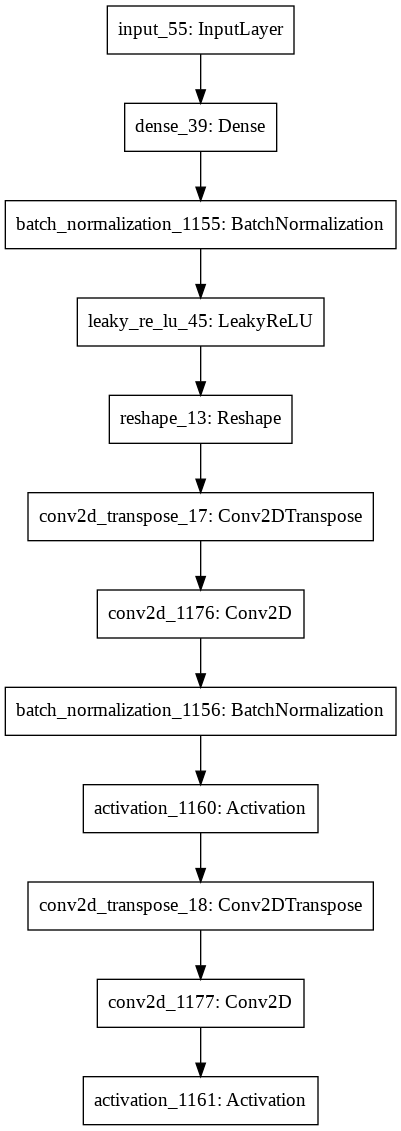

In [ ]:
from enum import Enum
from tensorflow.keras.layers import Input, Dense, Reshape, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

class GeneratorParam(Enum):
    units_128_7_7 = 128*7*7
    leaky_relu_param_0_2 = 0.2
    reshape_size_7_7_128 = (7, 7, 128)

    conv2d_transpose_filter_64 = 64
    conv2d_transpose_kernel_2_2 = (2, 2)
    conv2d_transpose_stride_2_2 = (2, 2)

    conv2d_filter_64 = 64
    conv2d_kernel_3_3 = (3, 3)
    conv2d_padding_same = 'same'

    activation_relu = 'relu'

    conv2d_out_filter_1 = 1
    conv2d_out_kernel_5_5 = (5, 5)
    out_activation_tanh = 'tanh'

def generator_model(in_shape: tuple=(10,)) -> Model:
    """
    Parameters
    ----------
    in_shape : tuple
    Returns
    -------
    model: Model
    """
    inputs = Input(in_shape)
    fc1 = Dense(input_dim=in_shape[0], units=GeneratorParam.units_128_7_7.value)(inputs)
    # Techniques for stabilizing training
    fc1 = BatchNormalization()(fc1)
    fc1 = LeakyReLU(GeneratorParam.leaky_relu_param_0_2.value)(fc1)
    # Processing to convert to image size 7x7
    fc2 = Reshape(GeneratorParam.reshape_size_7_7_128.value, input_shape=(GeneratorParam.units_128_7_7.value,))(fc1)
    # Processing to convert to image size 14x14
    up1 = Conv2DTranspose(GeneratorParam.conv2d_transpose_filter_64.value,
                          GeneratorParam.conv2d_transpose_kernel_2_2.value,
                          strides=GeneratorParam.conv2d_transpose_stride_2_2.value,
                          padding=GeneratorParam.conv2d_padding_same.value)(fc2)
    conv1 = Conv2D(GeneratorParam.conv2d_filter_64.value,
                   GeneratorParam.conv2d_kernel_3_3.value,
                   padding=GeneratorParam.conv2d_padding_same.value)(up1)
    # Techniques for stabilizing training
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation(GeneratorParam.activation_relu.value)(conv1)
    # Processing to convert to image size 28x28
    up2 = Conv2DTranspose(GeneratorParam.conv2d_transpose_filter_64.value,
                          GeneratorParam.conv2d_transpose_kernel_2_2.value,
                          strides=GeneratorParam.conv2d_transpose_stride_2_2.value,
                          padding=GeneratorParam.conv2d_padding_same.value)(conv1)
    # Convert channels to 1 channel for grayscale image
    conv2 = Conv2D(GeneratorParam.conv2d_out_filter_1.value,
                   GeneratorParam.conv2d_out_kernel_5_5.value,
                   padding=GeneratorParam.conv2d_padding_same.value)(up2)
    outputs = Activation(GeneratorParam.out_activation_tanh.value)(conv2)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

g_model = generator_model()
g_model.summary()
plot_model(g_model, to_file='g_model.png')

# Discriminator

In [ ]:
class DiscriminatorParam(Enum):
    conv2d_filter_64 = 64
    conv2d_kernel_5_5 = (5, 5)
    conv2d_stride_2_2 = (2, 2)
    conv2d_padding_same = 'same'

    leaky_reLU_param_0_2 = 0.2

    conv2d_second_filter_128 = 128
    conv2d_second_kernel_5_5 = (5, 5)
    conv2d_second_stride_2_2 = (2, 2)
    conv2d_second_padding_same = 'same'

    dense_1 = 1

    out_activation_sigmoid = 'sigmoid'

Model: "model_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1178 (Conv2D)         (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1179 (Conv2D)         (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 627

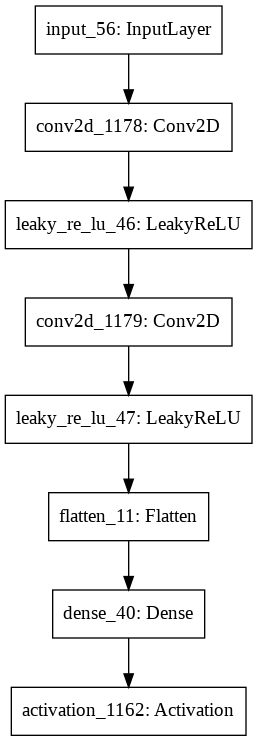

In [ ]:
def discriminator_model(image_shape: tuple=(28, 28, 1)) -> Model:
    """
    Create a Discriminator model

    Parameters
    ----------
    image_shape : tuple
        Dimension of the image

    Returns
    -------
    model: Model
        Created discriminator model
    """
    inputs = Input(image_shape)
    # Convert image to feature maps of size 14x14x64
    conv1 = Conv2D(DiscriminatorParam.conv2d_filter_64.value,
                   DiscriminatorParam.conv2d_kernel_5_5.value,
                   strides=DiscriminatorParam.conv2d_stride_2_2.value,
                   padding=DiscriminatorParam.conv2d_padding_same.value)(inputs)
    conv1 = LeakyReLU(DiscriminatorParam.leaky_reLU_param_0_2.value)(conv1)
    # Convert image to feature maps of size 7x7x128
    conv2 = Conv2D(DiscriminatorParam.conv2d_second_filter_128.value,
                   DiscriminatorParam.conv2d_second_kernel_5_5.value,
                   strides=DiscriminatorParam.conv2d_second_stride_2_2.value,
                   padding=DiscriminatorParam.conv2d_second_padding_same.value)(conv1)
    conv2 = LeakyReLU(DiscriminatorParam.leaky_reLU_param_0_2.value)(conv2)
    fc1 = Flatten()(conv2)
    # Single class output for fake and real classification
    fc1 = Dense(DiscriminatorParam.dense_1.value)(fc1)
    outputs = Activation(DiscriminatorParam.out_activation_sigmoid.value)(fc1)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

d_model = discriminator_model()
d_model.summary()
plot_model(d_model, to_file='d_model.png')

# Generator contatining Discriminator

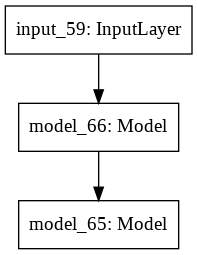

In [ ]:
def generator_containing_discriminator(g: Model, d: Model, in_shape: tuple=(10,)) -> Model:
    """
    Composite of Discriminator and Generator models

    Parameters
    ----------
    g : Model
        Generator model
    d : Model
        Discriminator model

    Returns
    -------
    gan : Model
        Composite model for training the Generator only without training the Discriminator
    """
    # Setting to train only the Generator
    d.trainable = False
    # Setting for inputting noise
    ganInput = Input(shape=in_shape)
    # Input noise to the Generator
    x = g(ganInput)
    # Input generated image to the Discriminator
    ganOutput = d(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    return gan

d_model = discriminator_model()
g_model = generator_model()
g_d_model = generator_containing_discriminator(g_model, d_model)
plot_model(g_d_model, to_file='g_d_model.png')


# Combine Images

In [ ]:
def combine_images(generated_images: np.ndarray) -> np.ndarray:
    """
    Combine generated images to check the progress of training

    Parameters
    ----------
    generated_images : np.ndarray
        Generated images for a batch

    Returns
    -------
    image: np.ndarray
        Combined image containing all generated images
    """
    # Number of generated images
    num = generated_images.shape[0]
    # Width of generated images
    width = int(math.sqrt(num))
    # Height of generated images
    height = int(math.ceil(float(num) / width))
    # Get the shape of generated images (height, width, channels)
    shape = generated_images.shape[1:4]
    # Scale the height and width
    image = np.zeros((height * shape[0], width * shape[1], shape[2]), dtype=generated_images.dtype)
    # Embed each generated image into a larger image
    for index, img in enumerate(generated_images):
        i = int(index / width)
        j = index % width
        image[i * shape[0]: (i+1) * shape[0], j * shape[1]: (j + 1) * shape[1], :] = img[:, :, :]
    return image


# Load Model

In [ ]:
def load_models(common_path: str=DataParm.common_path.value) -> Tuple[Model, Model]:
    """
    Load trained Generator and Discriminator models

    Parameters
    ----------
    common_path : str
        Path to load the models from

    Returns
    -------
    g: Model
        Generator model
    d: Model
        Discriminator model
    """
    d = load_model(common_path + '/weights/discriminator.h5')
    g = load_model(common_path + '/weights/generator.h5')
    return g, d


## TensorBoard Configuration

In [ ]:
def write_log(callback, names, logs, epoch):
    """
   

    """
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, epoch)
        callback.writer.flush()


log_path = DataParm.common_path.value + '/logs'
callback = TensorBoard(log_path)

## Calculate Inception Score

Compute the quality and diversity of images


In [ ]:
def scale_images(images: np.asarray, new_shape: tuple) -> np.asarray:
    """
    Resize images to a new shape (suitable for inference with Inception Model)

    Parameters
    ----------
    images: np.asarray
        Batch of image data
    new_shape: tuple
        Desired shape of the images

    Returns
    -------
    np.asarray
        List of resized images
    """
    images_list = list()
    for image in images:
        # Resize the image
        new_image = resize(image, new_shape, 0)
        # Store the resized image in a list
        images_list.append(new_image)
    return np.array(images_list)


def calculate_inception_score(images: np.asarray, model: Model=InceptionV3(), n_split: int=10, eps: float=1E-16) -> Tuple[float, float]:
    """
    Calculate the mean and standard deviation of Inception Score

    Parameters
    ----------
    images: np.asarray
        Multiple image data
    model: Model
        Model for inference
    n_split: int
        Number of groups to split the multiple image data into
    eps: float
        Value added to prevent log calculation from becoming zero

    Returns
    -------
    is_avg: float
        Inception Score mean
    is_std: float
        Inception Score standard deviation
    """
    scores = list()
    # Calculate the number of groups
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # Get images for each group
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # Convert to float32
        subset = subset.astype("float32")
        # Resize to a shape suitable for Inception Model
        subset = scale_images(subset, (299, 299, 3))
        # Preprocess images to [-1,1]
        subset = preprocess_input(subset)
        # Infer p(y|x)
        p_yx = model.predict(subset)
        # Infer p(y) for each class
        p_y = np.expand_dims(p_yx.mean(axis=0), 0)
        # Calculate KL divergence of log probabilities
        kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
        # Sum of KL divergence for each class
        sum_kl_d = kl_d.sum(axis=1)
        # Mean of KL divergence
        avg_kl_d = np.mean(sum_kl_d)
        # Convert KL divergence back from log domain
        is_score = np.exp(avg_kl_d)
        # Store in a list
        scores.append(is_score)
    # Calculate mean and standard deviation
    is_avg, is_std = np.mean(scores), np.std(scores)
    return is_avg, is_std


## Calculate FID

Compute the distance from real images


# Train


In [ ]:
class TrainParam(Enum):
    discriminator_lr_0_0004 = 0.0004
    generator_lr_0_0002 = 0.0002

    discriminator_loss_mse = "mse"
    generator_loss_mse = "mse"

In [ ]:
def train(batch_size: int, X_train: np.ndarray, epoch: int=10, common_path: str=DataParm.common_path.value) -> Tuple[Model, Model]:
    """
    Train the Discriminator and Generator models

    Parameters
    ----------
    batch_size: int
        Batch size
    X_train: np.ndarray
        Training image data
    epoch: int
        Number of epochs for training
    common_path : str
        Path to save the models and generated images

    Returns
    -------
    d: Model
        Trained Discriminator model
    g: Model
        Trained Generator model

    """
    d = discriminator_model()
    g = generator_model()
    # Composite model for training the Generator model
    d_on_g = generator_containing_discriminator(g, d)
    # Optimizer setup
    d_optim = RMSprop(lr=TrainParam.discriminator_lr_0_0004.value)
    g_optim = RMSprop(lr=TrainParam.generator_lr_0_0002.value)
    g.compile(loss=TrainParam.generator_loss_mse.value, optimizer=g_optim)
    d_on_g.compile(loss=TrainParam.discriminator_loss_mse.value, optimizer=g_optim)
    d.trainable= True
    d.compile(loss=TrainParam.discriminator_loss_mse.value, optimizer=d_optim)
    # Inception score model
    is_model = InceptionV3(include_top=True, input_shape=(299, 299, 3))
    # Feature extraction model
    fid_model = InceptionV3(include_top=False, pooling="avg", input_shape=(299, 299, 3))

    for e in range(epoch):
        print('Epoch is ', e)
        # Calculate how many batches can be processed in the dataset size / batch size
        n_iter = int(X_train.shape[0] / batch_size)
        # Display progress of training for better understanding
        progress_bar = Progbar(target=n_iter)

        for index in range(n_iter):
            # Generate 10-dimensional noise for batch size
            noise = np.random.uniform(0, 1, size=(batch_size, 10))
            # Get images for batch size
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            # Generate images from noise
            generated_images = g.predict(noise, verbose=0)

            # Save generated images for later inspection
            if index % 20 == 0:
                # Convert batch size images to a single image
                image = combine_images(generated_images)
                # Convert from -1 to 1 scale to 0 to 255 scale
                image = image * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value

                if not os.path.exists(common_path + '/result/'):
                    os.makedirs(common_path + '/result/')
                cv2.imwrite(common_path + '/result/' + str(e) + '_' + str(index) + '.png', image)

            # Combine real images and generated images
            x = np.concatenate((image_batch, generated_images))
            # Labels for real images and generated images
            y = np.array([1] * batch_size + [0] * batch_size)

            # Train the Discriminator
            d_loss = d.train_on_batch(x, y)

            # Do not train the Discriminator
            d.trainable = False

            # Train the Generator
            g_loss = d_on_g.train_on_batch(noise, np.array([1] * batch_size))
            d.trainable = True

            # Display the progress of training using progress bar
            progress_bar.update(index, values=[('g', g_loss), ('d', d_loss)])

        # Write to Tensorboard
        callback.set_model(d)
        write_log(callback, ['d_loss'], [d_loss], e)

        callback.set_model(d_on_g)
        # Calculate Inception Score
        is_avg, is_std = calculate_inception_score(generated_images, is_model)
        # Calculate FID
        fid = calculate_fid(image_batch, generated_images, fid_model)

        write_log(callback, ['g_loss', 'inception_score_average', 'inception_score_std', 'fid'], [g_loss, is_avg, is_std, fid], e)

        print('')
        # Save the trained Generator and Discriminator models
        if not os.path.exists(common_path + '/weights/'):
            os.makedirs(common_path + '/weights/')
        g.save(common_path + '/weights/generator.h5')
        d.save(common_path + '/weights/discriminator.h5')
    return d, g


# Data Generation Using Generator


In [ ]:
def generate(batch_size: int, common_path: str=DataParm.common_path.value, noise_size: int=10) -> np.ndarray:
    """
    Generate images using the Generator model

    Parameters
    ----------
    batch_size: int
        Batch size
    common_path : str
        Path to load the models
    noise_size: int
        Dimension of noise

    Returns
    -------
    generated_images: np.ndarray
        Generated images in numpy format

    """
    g = load_model(common_path + '/weights/generator.h5')
    noise = np.random.uniform(0, 1, (batch_size, noise_size))
    generated_images = g.predict(noise)
    return generated_images


# Setting Residual Loss


In [ ]:
def sum_of_residual(y_true: np.array, y_pred: np.array):
    """
    Function to calculate the anomaly of the Generator and Discriminator models

    Parameters
    ----------
    y_true: np.array
        Target data
    y_pred: np.array
        Predicted values by the model

    Returns
    -------
        Calculate the Residual Loss

    """
    return K.sum(K.abs(y_true - y_pred))


# Feature Extractor

In [ ]:
class FeatureExtractorParam(Enum):
    loss_binary_crossentropy = "binary_crossentropy"
    optimizer_rmsprop = "rmsprop"
    feature_extract_layer_first_conv = -7

Model: "model_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1372 (Conv2D)         (None, 14, 14, 64)        1664      
Total params: 1,664
Trainable params: 1,664
Non-trainable params: 0
_________________________________________________________________


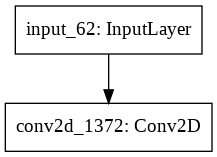

In [ ]:
def feature_extractor(d: Model=None, common_path: str=DataParm.common_path.value) -> Model:
    """
    Get the feature extractor model from the Discriminator model

    Parameters
    ----------
    d: Model
        Discriminator model
    common_path: str
        Path to load the models

    Returns
    -------
    intermediate_model: Model
        Feature extractor model

    """
    if d is None:
        d = load_model(common_path + '/weights/discriminator.h5')
        d.summary()
    # Set the feature extractor from the Discriminator
    intermediate_model = Model(inputs=d.layers[0].input, outputs=d.layers[FeatureExtractorParam.feature_extract_layer_first_conv.value].output)
    intermediate_model.compile(loss=FeatureExtractorParam.loss_binary_crossentropy.value, optimizer=FeatureExtractorParam.optimizer_rmsprop.value)
    return intermediate_model

d_model = discriminator_model()
f_model = feature_extractor(d_model)
f_model.summary()
plot_model(f_model, to_file='f_model.png')

# Anomaly Detector

In [ ]:
class AnomalyDetectorParam(Enum):
    activation_sigmoid = "sigmoid"
    optimizer_rmsprop = 'rmsprop'

Model: "model_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        (None, 10)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 10)                110       
_________________________________________________________________
activation_1358 (Activation) (None, 10)                0         
_________________________________________________________________
model_73 (Model)             (None, 28, 28, 1)         182145    
_________________________________________________________________
model_72 (Model)             (None, 14, 14, 64)        1664      
Total params: 183,919
Trainable params: 1,774
Non-trainable params: 182,145
_________________________________________________________________


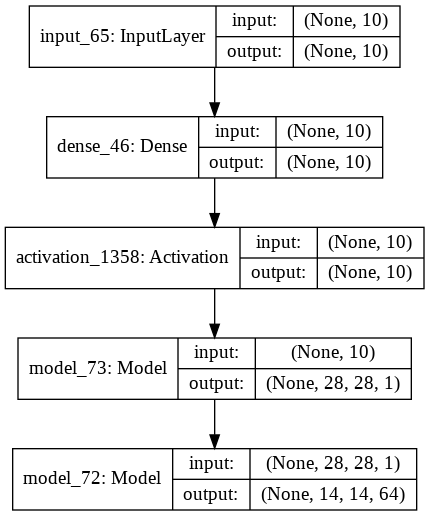

In [ ]:
def anomaly_detector(g: Model, d: Model, in_shape: tuple=(10,), loss_weights: list=[0.9, 0.1]) -> Model:
    """
    Create a model to generate anomaly scores and images by adjusting the layer to generate noise

    Parameters
    ----------
    g: Model
        Generator model
    d: Model
        Discriminator model
    in_shape: tuple
        Input size of noise
    loss_weights: list
        Setting the importance of loss

    Returns
    -------
    model: Model
        Model to generate anomaly scores and images

    """
    # Create feature extractor model from Discriminator
    intermidiate_model = feature_extractor(d)
    # Do not train the feature extractor model
    intermidiate_model.trainable = False
    # Create Generator
    g = Model(inputs=g.layers[1].input, outputs=g.layers[-1].output)
    # Do not train the Generator
    g.trainable = False
    # Layer to learn noise
    aInput = Input(shape=in_shape)
    gInput = Dense(in_shape[0], trainable=True)(aInput)
    gInput = Activation(AnomalyDetectorParam.activation_sigmoid.value)(gInput)

    # Generate image from noise input
    G_out = g(gInput)
    # Extract features from the generated image
    D_out = intermidiate_model(G_out)
    # Create a model that outputs images and features
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights=loss_weights, optimizer=AnomalyDetectorParam.optimizer_rmsprop.value)

    # Set BatchNorm to non-trainable
    K.set_learning_phase(0)

    return model

g_model = generator_model()
d_model = discriminator_model()
a_model = anomaly_detector(g_model, d_model)
a_model.summary()
plot_model(a_model, to_file="anomaly_plot.png", show_shapes=True, show_layer_names=True)


# Function to calculate anomaly scores


In [ ]:
def compute_anomaly_score(model: Model, x: np.array, iterations: int=500, d: Model=None, noise_shape: tuple=(1, 10)) -> Tuple[np.asarray, np.asarray,]:
    """
    Function to compute anomaly score

    Parameters
    ----------
    model: Model
        Model to compute anomaly score
    x: np.array
        Validation images
    iterations: int
        Number of iterations
    d: Model
        Discriminator model

    Returns
    -------
    loss: np.asarray
        Anomaly score
    similar_data: np.asarray
        Generated images by inputting noise to the model with adjusted noise
    """
    # Generate noise
    z = np.random.uniform(0, 1, size=noise_shape)
    # Create feature extractor model
    intermediate_model = feature_extractor(d)
    # Extract features of real images
    d_x = intermediate_model.predict(x)
    # Train noise with input as real images and target as real images and their features
    loss = model.fit(z, [x, d_x], batch_size=1, epochs=iterations, verbose=0)
    # Generate images from noise
    similar_data, _ = model.predict(z)
    # Compute anomaly score
    loss = loss.history['loss'][-1]

    return loss, similar_data


*   Get training and testing data
*   Scale the data to be between -1 and 1.
*   Use training data with label 1 for GAN training.
*   For validation, use testing data with label 1 and testing data with labels other than 1.










In [ ]:
# Get mnist images and labels
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Convert image scale to -1 to 1
X_train = (X_train.astype(np.float32) - DataParm.image_size_127_5.value) / DataParm.image_size_127_5.value
X_test = (X_test.astype(np.float32) - DataParm.image_size_127_5.value) / DataParm.image_size_127_5.value

# Convert to batch size, width, height, and channel
X_train = X_train[:,:,:,None]
X_test = X_test[:,:,:,None]

# Keep original images
X_test_original = X_test.copy()

# Target only images with label 1 for training
X_train = X_train[y_train==1]
X_test = X_test[y_test==1]


Train the data with label 1.

In [ ]:
%%time
batch_size = DataParm.batch_size_64.value
Model_d, Model_g = train(batch_size, X_train)

Eposh is  0
104/105 [============================>.] - ETA: 0s - g: 0.3003 - d: 0.2339
Eposh is  1
104/105 [============================>.] - ETA: 0s - g: 0.2953 - d: 0.2462
Eposh is  2
104/105 [============================>.] - ETA: 0s - g: 0.2795 - d: 0.2463
Eposh is  3
104/105 [============================>.] - ETA: 0s - g: 0.2801 - d: 0.2444
Eposh is  4
104/105 [============================>.] - ETA: 0s - g: 0.2823 - d: 0.2426
Eposh is  5
104/105 [============================>.] - ETA: 0s - g: 0.2876 - d: 0.2383
Eposh is  6
104/105 [============================>.] - ETA: 0s - g: 0.2953 - d: 0.2345
Eposh is  7
104/105 [============================>.] - ETA: 0s - g: 0.3047 - d: 0.2292
Eposh is  8
104/105 [============================>.] - ETA: 0s - g: 0.3155 - d: 0.2235
Eposh is  9
104/105 [============================>.] - ETA: 0s - g: 0.3252 - d: 0.2208
CPU times: user 18min 29s, sys: 2min, total: 20min 30s
Wall time: 17min 11s


Check the Tensorboard logs

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir {your path}/logs/

Function to calculate anomaly scores.

In [ ]:
def anomaly_detection(test_img: np.asarray, g: Model, d: Model, iteration: int=200) -> Tuple[np.asarray, np.asarray, np.asarray, np.asarray]:
    """
    Function to calculate anomaly scores.

    Parameters
    ----------
    test_img: np.asarray
        Test image for validation.
    g: Model
        Model for calculating anomaly scores.
    d: Model
        Discriminator model.
    iteration: int
        Number of iterations.

    Returns
    -------
    ano_score: np.asarray
        Anomaly scores.
    original_x: np.asarray
        Test images adjusted to the pixel area of 0-255.
    similar_x: np.asarray
        Images generated from the model used to calculate anomaly scores.
    show: np.asarray
        Difference between the test images and the generated images.
    """
    # Anomaly score calculation model
    model = anomaly_detector(g=g, d=d)
    # Get the shape of the image
    test_img_shape = test_img.shape
    # Estimate anomaly scores and similar images from test images
    ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, test_img_shape[0], test_img_shape[1], test_img_shape[2]), iterations=iteration, d=d)

    # Derive the difference between the original image and the similar image
    np_residual = test_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) - similar_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2])
    np_residual = (np_residual + 2) / 4

    # Convert to uint8 and multiply by 255 to obtain the pixel area of 0-255
    np_residual = (255 * np_residual).astype(np.uint8)
    # Adjust both original and similar images to the 0-255 pixel area
    original_x = (test_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value).astype(np.uint8)
    similiar_x = (similar_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value).astype(np.uint8)

    # Convert to GRAY color image
    original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x_color, 0.3, residual_color, 0.7, 0.)

    return ano_score, original_x, similiar_x, show


Prepare an abnormal image with the digit 7.

In [ ]:
img_index = 14
label_index = 7
test_image = X_test_original[y_test==label_index][img_index]

Retrieve the pre-trained generator model and discriminator model.

In [ ]:
g, d  = load_models(common_path=DataParm.common_path.value)

Calculate the anomaly score, obtain the validation images, predicted images, and differential images.

In [ ]:
%%time
start = cv2.getTickCount()
score, query, pred, diff = anomaly_detection(test_image, g=g, d=d, iteration=200)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 100
print ('%d label, %d : done'%(label_index, img_index), '%.2f' %score, '%.2fms' %time)

7 label, 14 : done 175.33 6429.97ms
CPU times: user 1min 3s, sys: 1.09 s, total: 1min 4s
Wall time: 1min 4s


Since the model was trained on images labeled as 1, providing a 7 as input will generate a difference between the generated image and the expected image of 1.

anomaly score :  175.3253173828125


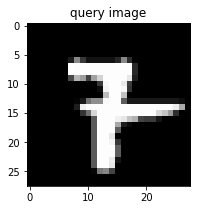

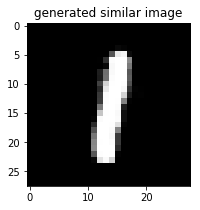

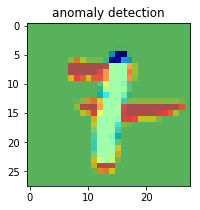

In [ ]:
plt.figure(1, figsize=(3, 3))
plt.title('query image')
plt.imshow(query.reshape(28,28), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(3, 3))
plt.title('generated similar image')
plt.imshow(pred.reshape(28,28), cmap=plt.cm.gray)

plt.figure(3, figsize=(3, 3))
plt.title('anomaly detection')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()

# Observing Feature Space of Noisy Images, Images of Digit 1, and Images of Other Digits

random noise image


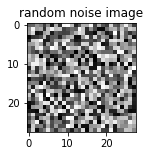

In [ ]:
# Create 100 Images of Size 28x28x1
random_image = np.random.uniform(0, 1, (100, 28, 28, 1))
print("random noise image")
plt.figure(4, figsize=(2, 2))
plt.title('random noise image')
plt.imshow(random_image[0].reshape(28,28), cmap=plt.cm.gray)

To visualize and inspect the images, let's extract the features

In [ ]:
model = feature_extractor()
# Extract features from random images
feature_map_of_random = model.predict(random_image, verbose=1)
# Extract features from images with labels not equal to 1
feature_map_mnist = model.predict(X_test_original[y_test != 1][:300], verbose=1)
# Extract features from images with label 1
feature_map_mnist_1 = model.predict(X_test[:100], verbose=1)


Model: "model_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1570 (Conv2D)         (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_59 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1571 (Conv2D)         (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 627

Aggregate the features into a single dataset.

In [ ]:
# Combine the feature spaces obtained earlier
output = np.concatenate((feature_map_of_random, feature_map_mnist, feature_map_mnist_1))
# Keep only the first dimension while combining the rest
output = output.reshape(output.shape[0], -1)


Visualize the features in a 2-dimensional space.

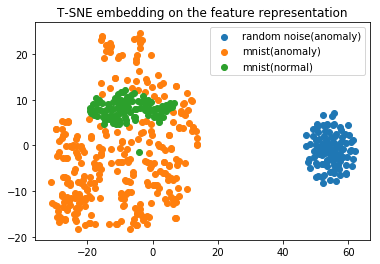

In [ ]:
# Compress the feature space into 2 dimensions for visualization
X_embedded = TSNE(n_components=2).fit_transform(output)
plt.figure(5)
plt.title("T-SNE embedding on the feature representation")
plt.scatter(X_embedded[:100, 0], X_embedded[:100, 1], label='random noise (anomaly)')
plt.scatter(X_embedded[100:400, 0], X_embedded[100:400, 1], label='mnist (anomaly)')
plt.scatter(X_embedded[400:, 0], X_embedded[400:, 1], label='mnist (normal)')
plt.legend()
plt.show()

# Changing the computation of anomaly scores
Modify noise generation to generate multiple noises.
Perform training on the Generator model.






In [ ]:
%%time
def anomaly_detector_second(g: Model, d: Model, in_shape: tuple=(10,), loss_weights: list=[0.9, 0.1]) -> Model:
    """
    Create a model to generate anomaly scores and images by adjusting the noise generation layer and the generator model.

    Parameters
    ----------
    g: Model
        Generator model
    d: Model
        Discriminator model
    in_shape: tuple
        Input size of noise
    loss_weights: list
        Set the importance of loss

    Returns
    -------
    model: Model
        Model to generate anomaly scores and images

    """
    # Create a feature extraction model from the Discriminator
    intermidiate_model = feature_extractor(d)
    # Do not train the feature extraction model
    feature_extractor.trainable = False
    # Create a Generator
    g = Model(inputs=g.layers[1].input, outputs=g.layers[-1].output)
    # Train the Generator
    g.trainable = True
    # Layer for learning noise
    aInput = Input(shape=in_shape)
    gInput = Dense(in_shape[0], trainable=True)(aInput)
    gInput = Activation(AnomalyDetectorParam.activation_sigmoid.value)(gInput)

    # Generate images from noise input
    G_out = g(gInput)
    # Extract features from images
    D_out = intermidiate_model(G_out)
    # Create a model that outputs images and features
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights=loss_weights, optimizer=AnomalyDetectorParam.optimizer_rmsprop.value)

    # Fix BatchNorm to avoid training
    K.set_learning_phase(0)

    return model


def compute_anomaly_score_second(model: Model, x: np.array, iterations: int=5, z_num: int=5, d: Model=None, g: Model=None, noize_shape: tuple=(1, 10)) -> Tuple[np.asarray, np.asarray,]:
    """
    Function to compute anomaly scores

    Parameters
    ----------
    model: Model
        Model to compute anomaly scores
    x: np.array
        Verification images
    iterations: int
        Set the iterations
    z_num: int
        Set the number of noises to generate
    d: Model
        Discriminator model
    g: Model
        Generator model
    noize_shape: tuple
        Set the dimension of noise

    Returns
    -------
    loss: np.asarray
        Anomaly scores
    similar_data: np.asarray
        Images generated by adjusting noise to the model
    """
    loss_list = []
    similar_data_list = []
    # Maintain the initial state of the Generator that is not trained
    initial_g = copy.deepcopy(g)

    # Generate multiple noises and take the average
    for i in range(z_num):
        z = np.random.uniform(0, 1, size=noize_shape)
        # Create a feature extraction model
        intermidiate_model = feature_extractor(d)
        # Extract features from real images
        d_x = intermidiate_model.predict(x)
        # Learn noise with real images and features as targets
        loss = model.fit(z, [x, d_x], batch_size=1, epochs=iterations, verbose=0)
        # Generate images from noise
        similar_data, _ = model.predict(z)
        # Derive anomaly scores
        loss = loss.history['loss'][-1]
        loss_list.append(loss)
        similar_data_list.append(similar_data)
        # Reset to a model that does not train the Generator
        model = anomaly_detector_second(g=initial_g, d=d)

    average_loss = np.average(loss_list)
    average_similar_data = np.average(similar_data_list, axis=0)

    return average_loss, average_similar_data


def anomaly_detection_second(test_img, g=None, d=None, iterations: int=5) -> Tuple[np.asarray, np.asarray, np.asarray, np.asarray,]:
    """
    Function to compute anomaly scores (adjust Generator, adjust number of noise generations)

    Parameters
    ----------
    test_img: np.asarray
        Verification images
    g: Model
        Model to compute anomaly scores
    d: Model
        Discriminator model
    iterations: int
        Set the iterations

    Returns
    -------
    ano_score: np.asarray
        Anomaly scores
    original_x: np.asarray
       Verification images adjusted to the pixel range of 0-255
    similiar_x: np.asarray
       Images generated from the model that computes anomaly scores
    show:
       Difference between verification images and generated images
    """
    # Model to compute anomaly scores
    model = anomaly_detector_second(g=g, d=d)
    # Get the shape of the image
    test_img_shape = test_img.shape
    # Estimate anomaly scores and similar images from the test images
    ano_score, similar_img = compute_anomaly_score_second(model, test_img.reshape(1, test_img_shape[0], test_img_shape[1], test_img_shape[2]), iterations=iterations, d=d, g=g)

    # Derive the difference between real images and


7 label, 14 : done 262.81 43877.68ms
CPU times: user 9min 15s, sys: 8.2 s, total: 9min 23s
Wall time: 9min 23s


Change the approach to compute anomaly scores and output verification data, anomaly data, and their differences

anomaly score :  262.8119873046875


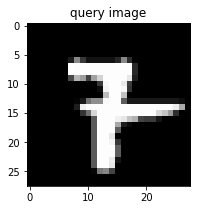

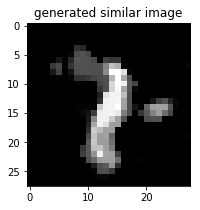

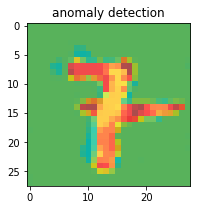

In [ ]:
plt.figure(1, figsize=(3, 3))
plt.title('query image')
plt.imshow(query.reshape(28,28), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(3, 3))
plt.title('generated similar image')
plt.imshow(pred.reshape(28,28), cmap=plt.cm.gray)

plt.figure(3, figsize=(3, 3))
plt.title('anomaly detection')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()

# EfficentGAN-BasedAnomalyDetection

Implementation of a high-speed anomaly detection GAN

# Discriminator

- Discriminator that takes noise and images as input.

In [ ]:
class DiscriminatorEncoderParam(Enum):
    conv2d_filter_64 = 64
    conv2d_kernel_4_4 = (4, 4)
    conv2d_stride_2_2 = (2, 2)
    conv2d_padding_same = 'same'

    leaky_relu_param_0_2 = 0.2
    drop_out_0_4 = 0.4

    noize_size_5_5_64 = 5 * 5 * 64

    leaky_relu_param_0_1 = 0.1

    dense_1024 = 1024

    out_dense_1 = 1
    out_activation_sigmoid = 'sigmoid'
    adam_lr_0_0002 = 0.0002
    beta_1_0_5 = 0.5
    loss_binary_crossentropy = "binary_crossentropy"
    metrics_accuracy = 'accuracy'

Model: "model_109"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_83 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1762 (Conv2D)            (None, 14, 14, 64)   1088        input_83[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_62 (LeakyReLU)      (None, 14, 14, 64)   0           conv2d_1762[0][0]                
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 14, 14, 64)   0           leaky_re_lu_62[0][0]             
__________________________________________________________________________________________

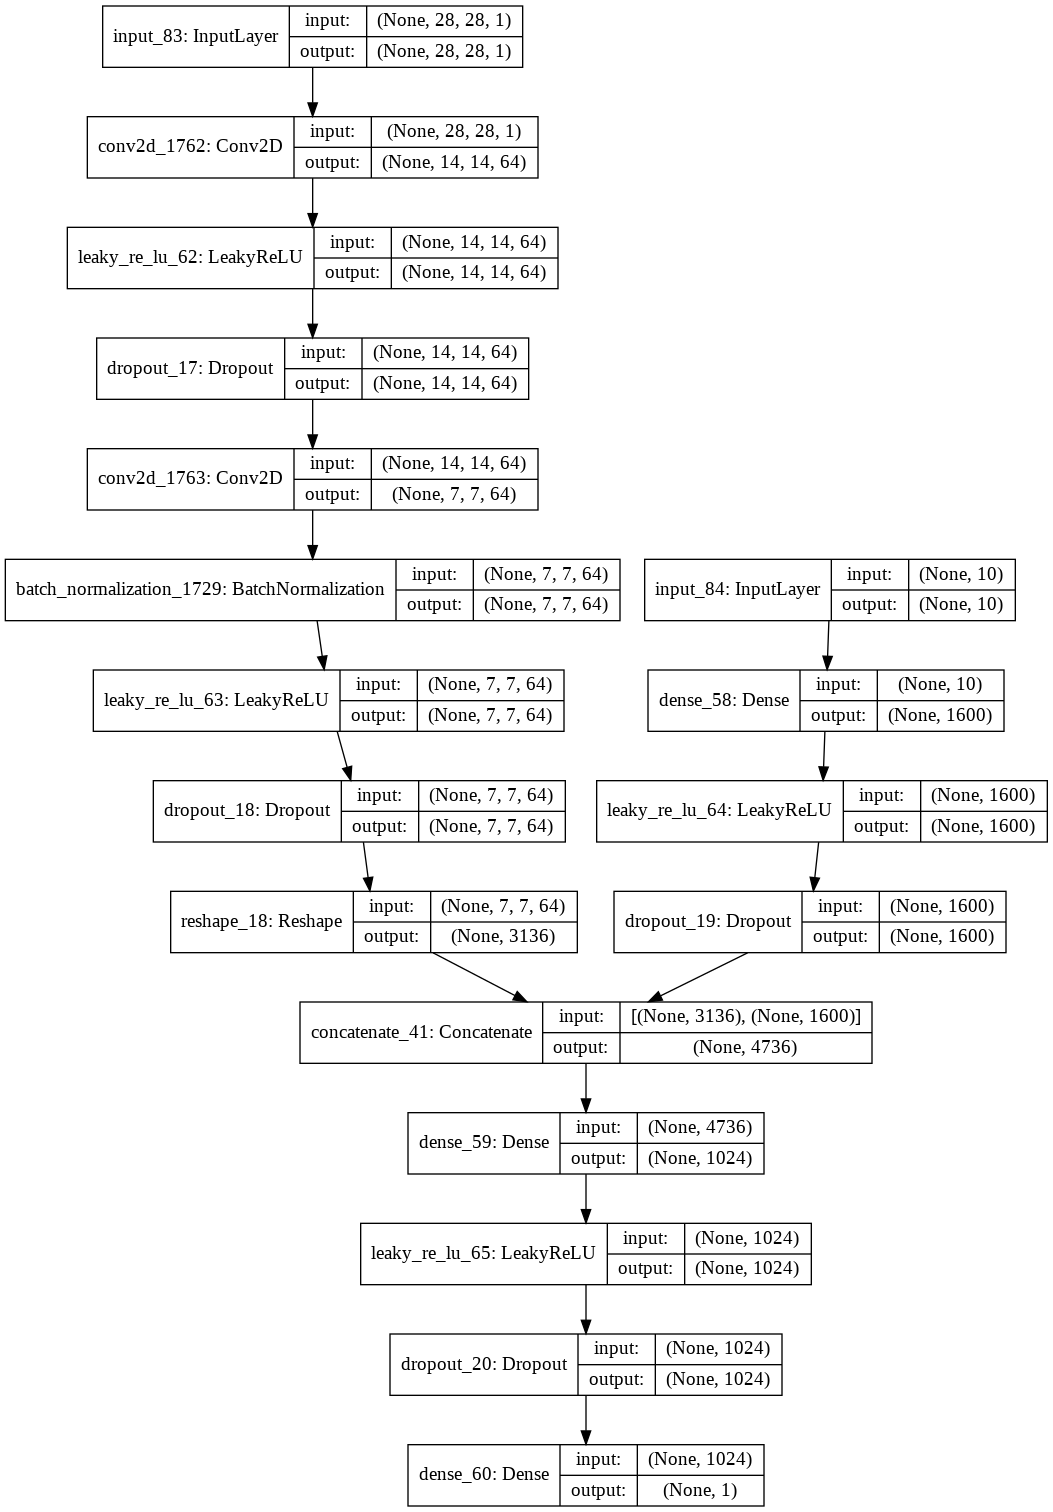

In [ ]:
def define_discriminator(in_shape=(28,28,1), in_z=(10,)) -> Model:
    """
    Create the discriminator model.

    Parameters
    ----------
    in_shape : tuple
        Dimensions of the image.
    in_z : tuple
        Dimensions of the noise.

    Returns
    -------
    model: Model
        The created discriminator model (taking noise and image as input).
    """

    input_x = Input(shape=in_shape)
    x = Conv2D(DiscriminatorEncoderParam.conv2d_filter_64.value,
               DiscriminatorEncoderParam.conv2d_kernel_4_4.value,
               strides=DiscriminatorEncoderParam.conv2d_stride_2_2.value,
               padding=DiscriminatorEncoderParam.conv2d_padding_same.value,
               input_shape=in_shape)(input_x)

    x = LeakyReLU(alpha=DiscriminatorEncoderParam.leaky_relu_param_0_2.value)(x)
    x = Dropout(DiscriminatorEncoderParam.drop_out_0_4.value)(x)
    x = Conv2D(DiscriminatorEncoderParam.conv2d_filter_64.value,
               DiscriminatorEncoderParam.conv2d_kernel_4_4.value,
               strides=DiscriminatorEncoderParam.conv2d_stride_2_2.value,
               padding=DiscriminatorEncoderParam.conv2d_padding_same.value,
               input_shape=in_shape)(x)

    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=DiscriminatorEncoderParam.leaky_relu_param_0_2.value)(x)
    x = Dropout(DiscriminatorEncoderParam.drop_out_0_4.value)(x)
    # Get the size of the layer
    shape_x = K.int_shape(x)
    # Reshape to one dimension to concatenate with noise, excluding the batch size (0th dimension)
    x = Reshape((shape_x[1] * shape_x[2] * shape_x[3],))(x)

    # Layer for the input noise
    input_z = Input(shape=in_z)
    z = Dense(DiscriminatorEncoderParam.noize_size_5_5_64.value)(input_z)
    z = LeakyReLU(alpha=DiscriminatorEncoderParam.leaky_relu_param_0_1.value)(z)
    z = Dropout(DiscriminatorEncoderParam.drop_out_0_4.value)(z)

    # Concatenate noise and extracted image features
    concat_x = concatenate([x, z], axis=1)
    x = Dense(DiscriminatorEncoderParam.dense_1024.value)(concat_x)
    x = LeakyReLU(alpha=DiscriminatorEncoderParam.leaky_relu_param_0_1.value)(x)
    x = Dropout(DiscriminatorEncoderParam.drop_out_0_4.value)(x)
    x = Dense(DiscriminatorEncoderParam.out_dense_1.value, activation=DiscriminatorEncoderParam.out_activation_sigmoid.value)(x)

    # Discriminate using both noise and image information
    model = Model(inputs=[input_x, input_z], outputs=x)
    opt = Adam(lr=DiscriminatorEncoderParam.adam_lr_0_0002.value, beta_1=DiscriminatorEncoderParam.beta_1_0_5.value)
    model.compile(loss=DiscriminatorEncoderParam.loss_binary_crossentropy.value, optimizer=opt, metrics=[DiscriminatorEncoderParam.metrics_accuracy.value])
    return model

d_model = define_discriminator()
d_model.summary()
plot_model(d_model, to_file="d_plot.png", show_shapes=True, show_layer_names=True)


# Encoder

In [ ]:
class EncoderParam(Enum):
    con2d_filter_32 = 32
    con2d_kernel_3_3 = (3, 3)
    con2d_strides_2_2 = (2, 2)
    conv2d_padding_same = 'same'

    con2d_filter_64 = 64

    leaky_relu_param_0_2 = 0.2

    adam_lr_0_0002 = 0.0002
    beta_1_0_5 = 0.5
    loss_binary_crossentropy = "binary_crossentropy"
    metrics_accuracy = 'accuracy'

Model: "model_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_85 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1764 (Conv2D)         (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1765 (Conv2D)         (None, 7, 7, 32)          9248      
_________________________________________________________________
batch_normalization_1730 (Ba (None, 7, 7, 32)          128       
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1766 (Conv2D)         (None, 4, 4, 64)          18496     
_________________________________________________________________
batch_normalization_1731 (Ba (None, 4, 4, 64)          25

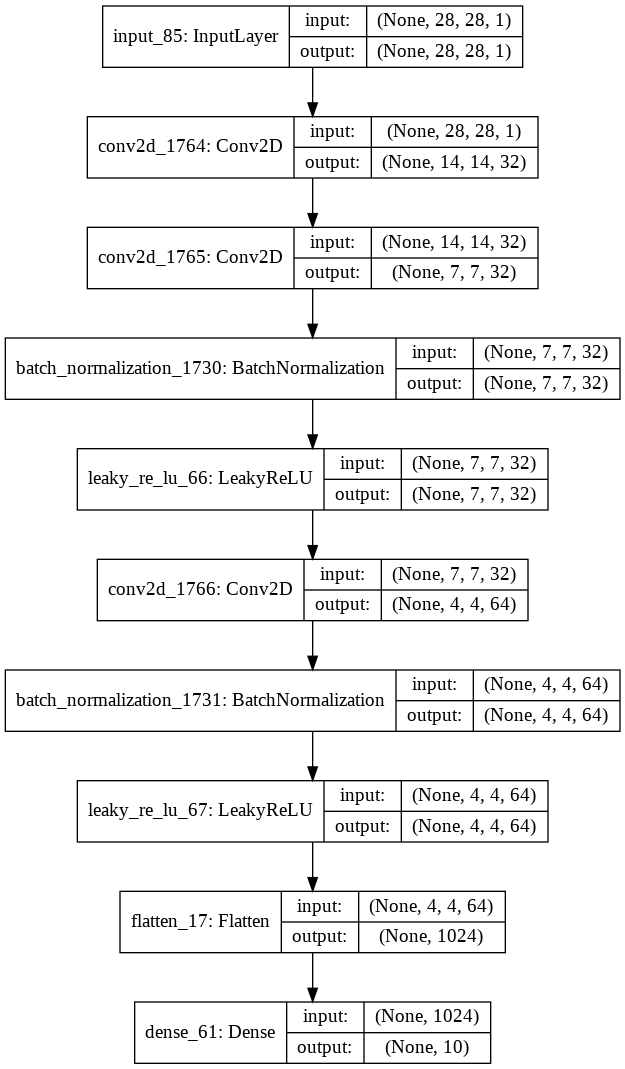

In [ ]:
def define_encoder(in_shape: tuple=(28, 28, 1), out_z: tuple=(10,)) -> Model:
    """
    Create the Encoder model.

    Parameters
    ----------
    in_shape : tuple
        Dimensions of the image.
    out_z : tuple
        Dimensions of the output noise.

    Returns
    -------
    model: Model
        The created Encoder model.
    """
    input_x = Input(shape=in_shape)
    x = Conv2D(EncoderParam.con2d_filter_32.value,
               EncoderParam.con2d_kernel_3_3.value,
               strides=EncoderParam.con2d_strides_2_2.value,
               padding=EncoderParam.conv2d_padding_same.value)(input_x)
    x = Conv2D(EncoderParam.con2d_filter_32.value,
               EncoderParam.con2d_kernel_3_3.value,
               strides=EncoderParam.con2d_strides_2_2.value,
               padding=EncoderParam.conv2d_padding_same.value)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=EncoderParam.leaky_relu_param_0_2.value)(x)
    x = Conv2D(EncoderParam.con2d_filter_64.value,
               EncoderParam.con2d_kernel_3_3.value,
               strides=EncoderParam.con2d_strides_2_2.value,
               padding=EncoderParam.conv2d_padding_same.value)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=EncoderParam.leaky_relu_param_0_2.value)(x)
    x = Flatten()(x)
    x = Dense(out_z[0])(x)
    model = Model(inputs=input_x, outputs=x)
    opt = Adam(lr=DiscriminatorEncoderParam.adam_lr_0_0002.value, beta_1=DiscriminatorEncoderParam.beta_1_0_5.value)
    model.compile(loss=DiscriminatorEncoderParam.loss_binary_crossentropy.value, optimizer=opt, metrics=[DiscriminatorEncoderParam.metrics_accuracy.value])
    return model

encoder_model = define_encoder()
encoder_model.summary()
plot_model(encoder_model, to_file="encoder_model_plot.png", show_shapes=True, show_layer_names=True)


# Configuration of the Discriminator with Noise Input

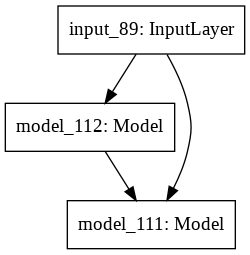

In [ ]:
def generator_containing_discriminator(g_model: Model, d_model: Model, in_z: tuple=(10,)) -> Model:
    """
    Creating a combined model of Generator and Discriminator for training the Generator

    Parameters
    ----------
    g_model : Model
        Generator model
    d_model : Model
        Discriminator model
    in_z : tuple
        Dimension of input noise

    Returns
    -------
    model: Model
        Combined model of Generator and Discriminator for training the Generator
    """
    d_model.trainable = False
    input_z = Input(shape=in_z)
    x = g_model(input_z)

    # Image and noise are inputs
    x = d_model([x, input_z])

    gan = Model(inputs=input_z, outputs=x)
    return gan

d_model = define_discriminator()
g_model = generator_model()
g_d_model = generator_containing_discriminator(g_model, d_model)
plot_model(g_d_model, to_file='g_d_model.png')


# Generating Noise from Encoder and Discriminating with Discriminator







Model: "model_116"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_93 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_115 (Model)               (None, 10)           38698       input_93[0][0]                   
__________________________________________________________________________________________________
model_114 (Model)               (None, 1)            4936257     input_93[0][0]                   
                                                                 model_115[1][0]                  
Total params: 4,974,955
Trainable params: 38,506
Non-trainable params: 4,936,449
__________________________________________________________________________________________________


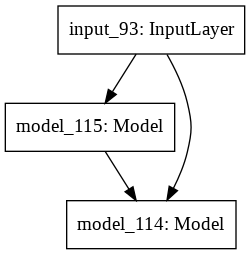

In [ ]:
def define_encoder_gan(e_model, d_model, in_shape=(28,28,1)) -> Model:
    """
    Creating a combined model of Encoder and Discriminator for learning

    Parameters
    ----------
    e_model : Model
        Encoder model
    d_model : Model
        Discriminator model
    in_shape : tuple
        Image dimensions

    Returns
    -------
    model: Model
        Combined model of Encoder and Discriminator for learning
    """
    d_model.trainable = False
    input_x = Input(shape=in_shape)
    # Convert image to noise with Encoder
    x = e_model(input_x)

    x = d_model([input_x, x])

    model = Model(inputs=input_x, outputs=x)
    return model

d_model = define_discriminator()
e_model = define_encoder()
gan_encoder_model = define_encoder_gan(e_model, d_model)
gan_encoder_model.summary()
plot_model(gan_encoder_model, to_file='gan_encoder_model.png')


# Training EfficientAnnoGAN including the Encoder

Occasionally, due to initial conditions, the Discriminator may become too strong. In such cases, retraining may be necessary.

Saving training logs using Tensorboard can be time-consuming, so it's not performed.



In [ ]:
class TrainEncoderParam(Enum):
    discriminator_lr = 0.0002
    generator_lr = 0.0002
    encoder_lr = 0.0002

    generator_loss = "mse"
    discriminator_generator_loss = "mse"
    discriminator_encoder_loss = "mse"
    discriminator_loss = 'mse'

In [ ]:
def train_encoder_gan(batch_size: int, X_train: np.ndarray, epoch: int=10, common_path: str='your model path') -> Tuple[Model, Model]:
    """
    Train the Discriminator and Generator models

    Parameters
    ----------
    batch_size: int
        Batch size
    X_train: np.ndarray
        Training image data
    epoch: int
        Number of epochs for training
    common_path : str
        Path to save the models and generated images

    Returns
    -------
    d: Model
        Discriminator model
    g: Model
        Generator model
    """
    d = define_discriminator()
    g = generator_model()
    encoder = define_encoder()

    # Composite model for training the Generator model
    d_on_g = generator_containint_discriminator(g, d)

    # Composite model for training the Encoder model
    d_on_e = define_encoder_gan(encoder, d)

    # Use Adam optimizer, which is considered to perform well
    d_optim = Adam(lr=TrainEncoderParam.discriminator_lr.value)
    g_optim = Adam(lr=TrainEncoderParam.generator_lr.value)
    e_optim = Adam(lr=TrainEncoderParam.encoder_lr.value)

    g.compile(loss=TrainEncoderParam.generator_loss.value, optimizer=g_optim)
    d_on_g.compile(loss=TrainEncoderParam.discriminator_generator_loss.value, optimizer=g_optim)
    d_on_e.compile(loss=TrainEncoderParam.discriminator_encoder_loss.value, optimizer=e_optim)

    d.trainable= True
    d.compile(loss=TrainEncoderParam.discriminator_loss.value, optimizer=d_optim)

    for e in range(epoch):
        print('Epoch is ', e)
        # Calculate how many batch processes can be performed with the data size divided by the batch size
        n_iter = int(X_train.shape[0] / batch_size)
        # Process to make the progress of training clear
        progress_bar = Progbar(target=n_iter)

        for index in range(n_iter):
            # Obtain 10-dimensional noise for the batch size, change to a normal distribution for better performance
            noise = np.random.normal(0, 1, size=(batch_size, 10))
            # Get images for the batch size
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            # Generate images from noise
            generated_images = g.predict(noise, verbose=0)
            # Generate noise from images
            generated_noise = encoder.predict(image_batch, verbose=0)

            # Save generated images for later inspection
            if index % 20 == 0:
                # Convert images for the batch size into a single image
                image = combine_images(generated_images)
                # Convert to 0-255 scale from -1 to 1 scale
                image = image * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value
                if not os.path.exists(common_path + '/result/'):
                    os.makedirs(common_path + '/result/')
                cv2.imwrite(common_path + '/result/' + str(e) + '_' + str(index) + '.png', image)


            # Training Discriminator
            y = np.array([1] * batch_size)
            d_loss = d.train_on_batch([image_batch, generated_noise], y)

            y = np.array([0] * batch_size)
            d_loss = d.train_on_batch([generated_images, noise], y)

            # Do not train Discriminator
            d.trainable = False

            # Training Generator
            g_loss = d_on_g.train_on_batch(noise, np.array([1] * batch_size))
            d.trainable = False
            # Training Encoder
            e_loss = d_on_e.train_on_batch(image_batch, np.array([0] * batch_size))

            d.trainable = True

            progress_bar.update(index, values=[('g', g_loss), ('d', d_loss), ('e', e_loss)])
        print('')
        # Create a directory to save the models
        if not os.path.exists(common_path + '/weights/'):
            os.makedirs(common_path + '/weights/')
        # Save the models
        g.save(common_path + '/weights/generator.h5')
        d.save(common_path + '/weights/discriminator.h5')
        encoder.save(common_path + '/weights/encoder.h5')
    return d, g, encoder

# Fix the random seed for reproducibility
np.random.seed(seed=30)
batch_size = 64
Model_d, Model_g, Model_e = train_encoder_gan(batch_size, X_train)


Eposh is  0
104/105 [============================>.] - ETA: 1s - g: 0.9456 - d: 0.0530 - e: 0.9844
Eposh is  1
104/105 [============================>.] - ETA: 0s - g: 0.9002 - d: 0.1003 - e: 0.9816
Eposh is  2
104/105 [============================>.] - ETA: 0s - g: 0.9535 - d: 0.0376 - e: 0.9605
Eposh is  3
104/105 [============================>.] - ETA: 0s - g: 0.7959 - d: 0.1723 - e: 0.8514
Eposh is  4
104/105 [============================>.] - ETA: 0s - g: 0.7682 - d: 0.1456 - e: 0.7643
Eposh is  5
104/105 [============================>.] - ETA: 0s - g: 0.7612 - d: 0.1576 - e: 0.6879
Eposh is  6
104/105 [============================>.] - ETA: 0s - g: 0.7610 - d: 0.1424 - e: 0.7418
Eposh is  7
104/105 [============================>.] - ETA: 0s - g: 0.6510 - d: 0.2184 - e: 0.5939
Eposh is  8
104/105 [============================>.] - ETA: 0s - g: 0.6875 - d: 0.1665 - e: 0.5817
Eposh is  9
104/105 [============================>.] - ETA: 0s - g: 0.5915 - d: 0.2134 - e: 0.5893


For models that include Encode, use the Feature Extraction function, anomaly
Modify the model creation function, anomaly score derivation function, etc.

In [ ]:
class FeatureExtractorEncodeParam(Enum):
    feature_extractor_loss = 'binary_crossentropy'
    optimizer = 'adam'

class AnomalyDetectorEncodeParam(Enum):
    adam = 'adam'

Model: "model_117"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_94 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1776 (Conv2D)            (None, 14, 14, 64)   1088        input_94[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_79 (LeakyReLU)      (None, 14, 14, 64)   0           conv2d_1776[0][0]                
__________________________________________________________________________________________________
dropout_29 (Dropout)            (None, 14, 14, 64)   0           leaky_re_lu_79[0][0]             
__________________________________________________________________________________________

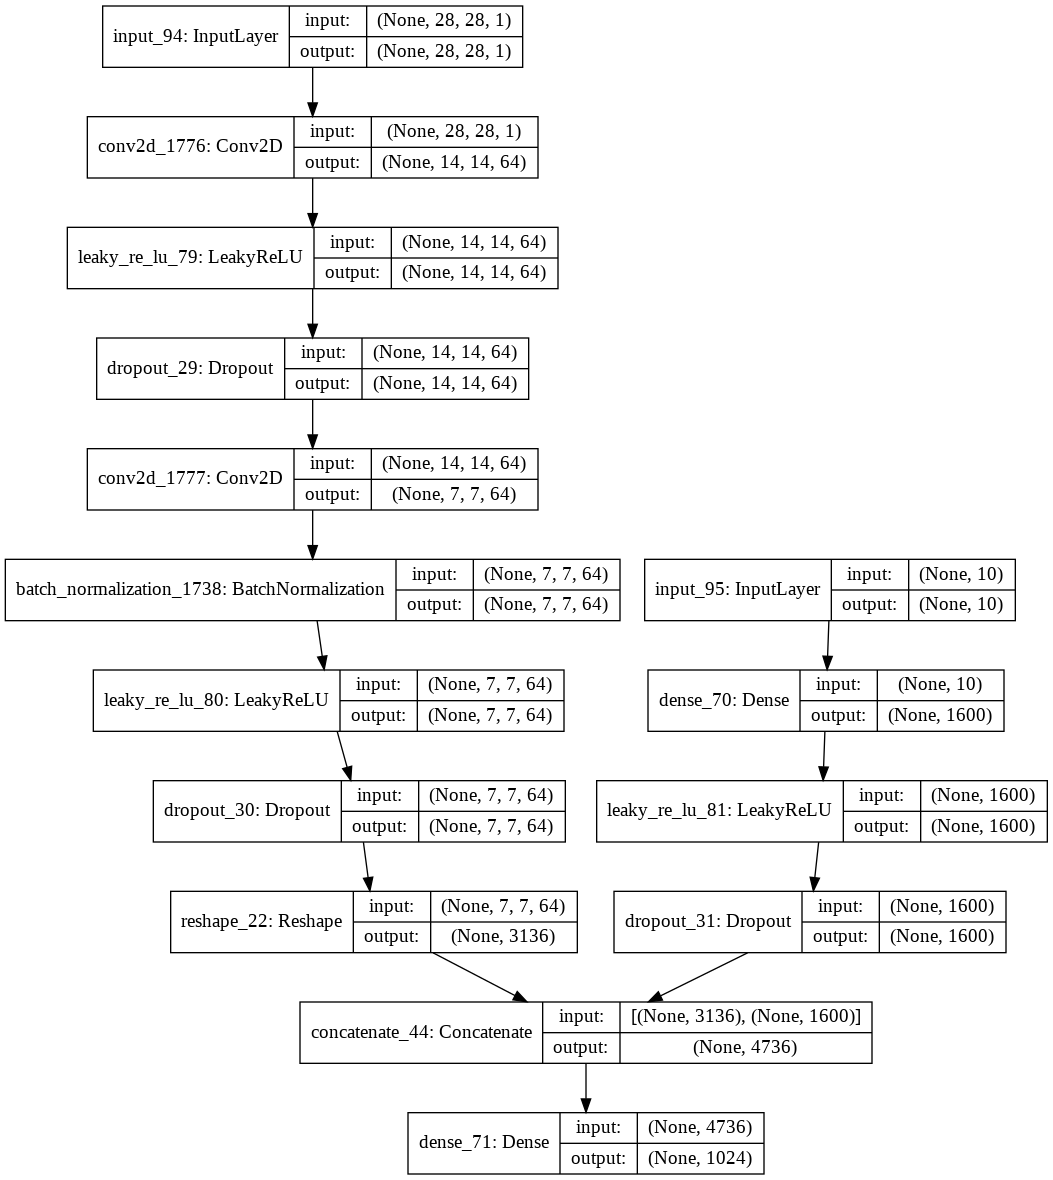

In [ ]:
def feature_extractor_encode(d: Model=None, common_path: str=DataParm.common_path_efficient.value) -> Model:
    """
    Get the feature extraction model from the discriminator model

    Parameters
    ----------
    d: Model
        Discriminator model
    common_path: str
        Path to load the model from

    Returns
    -------
    intermidiate_model: Model
        Feature extraction model

    """
    if d is None:
        d = load_model(common_path + '/weights/discriminator.h5')
        d.summary()
    input_layer = []
    # Since there are multiple input feature layers, reserve feature layers
    for index, each_d in enumerate(d.layers):
        if 'input' in each_d.name:
            input_layer.append(each_d.input)
    # Set the feature extractor of the discriminator
    intermidiate_model = Model(inputs=input_layer, outputs=d.layers[-4].output)
    intermidiate_model.compile(loss=FeatureExtractorEncodeParam.feature_extractor_loss.value, optimizer=FeatureExtractorEncodeParam.optimizer.value)
    return intermidiate_model

feature_extractor_model = feature_extractor_encode()
feature_extractor_model.summary()
plot_model(feature_extractor_model, to_file="feature_extractor_model_plot.png", show_shapes=True, show_layer_names=True)


# Anomaly score derivation by model including Encoder

In [ ]:
def anomaly_detector_encode(g: Model, d: Model, e: Model, img_shape: tuple=(28, 28, 1), loss_weights: list=[0.9, 0.1]) -> Model:
    """
    Create a model for deriving anomaly scores and generating images

    Parameters
    ----------
    g: Model
        Generator model
    d: Model
        Discriminator model
    e: Model
        Encoder model
    img_shape: tuple
        Input image size
    loss_weights: list
        Set the importance of the loss

    Returns
    -------
    model: Model
        Model for deriving anomaly scores and generating images

    """
    # Create a feature extraction model from the Discriminator
    intermidiate_model = feature_extractor_encode(d)
    # Do not train the feature extraction model
    intermidiate_model.trainable = False
    # Create a Generator model
    g = Model(inputs=g.layers[1].input, outputs=g.layers[-1].output)
    # Do not train the Generator
    g.trainable = False
    # Do not train the Encoder
    e.trainable = False
    # Create a model to output noise
    e = Model(inputs=e.layers[1].input, outputs=e.layers[-1].output)
    # Input the image
    aInput = Input(shape=img_shape)

    # Generate noise
    E_out = e(aInput)
    # Generate images from the noise input
    G_out = g(E_out)
    # Extract features from the images
    D_out = intermidiate_model([G_out, E_out])
    # Create a model to output images and features
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights=loss_weights, optimizer=AnomalyDetectorEncodeParam.adam.value)

    # Fix BatchNorm to not train
    K.set_learning_phase(0)

    return model

def compute_anomaly_score_encode(model: Model, intermidiate_model: Model, x: np.array, noise: np.array, d: Model=None, e: Model=None, g: Model=None) -> Tuple[np.asarray, np.asarray,]:
    """
    Function to compute anomaly scores

    Parameters
    ----------
    model: Model
        Model to compute anomaly scores
    intermidiate_model: Model
        Model to extract features
    x: np.array
        Validation images
    noise: np.array
        Noise
    d: Model
        Discriminator model
    e: Model
        Encoder model
    g: Model
        Generator model

    Returns
    -------
    loss: np.asarray
        Anomaly scores
    similar_data: np.asarray
        Images generated from adjusted noise by the model
    """
    # Generate noise
    generate_noise = e.predict(x)

    # Generate images
    generate_image = g.predict(generate_noise)

    # Extract features from the real images
    target_d_x = intermidiate_model.predict([x, generate_noise])

    # Extract features from the generated images
    d_x = intermidiate_model.predict([generate_image, noise])

    # Evaluate the loss of the real images and the real images plus generated noise
    # loss = model.evaluate(generate_image, [x, target_d_x], batch_size=1, verbose=0)
    # Generate images from noise
    similar_data, _ = model.predict(generate_image)
    # Compute the loss of the real images
    loss_image = [np.abs(each_x - g_x) for each_x, g_x in zip(x, generate_image)]
    sum_loss_image = np.sum(loss_image)
    # Compute the loss of the features
    loss_feature = [np.abs(each_d_x - each_g_d_x) for each_d_x, each_g_d_x in zip(target_d_x, d_x)]
    sum_loss_feature = np.sum(loss_feature)

    # Compute the anomaly scores
    loss = 0.9 * sum_loss_image + 0.1 * sum_loss_feature
    # loss = loss.history['loss'][-1]

    return loss, similar_data

def anomaly_detection_encode(test_img, noise, g=None, d=None, e=None, model=None, intermidiate_model=None) -> Tuple[np.asarray, np.asarray, np.asarray, np.asarray,]:
    """
    Function to compute anomaly scores (Adjustment of Generator and multiple noise generations)

    Parameters
    ----------
    test_img: np.asarray
        Validation images
    g: Model
        Generator model
    d: Model
        Discriminator model
    e: Model
        Encoder model
    model: Model
        Model to compute anomaly scores
    intermidiate_model: Model
        Model to extract features

    Returns
    -------
    ano_score: np.asarray
        Anomaly scores
    original_x: np.asarray
       Validation images adjusted to the 0-255 pixel range
    similiar_x: np.asarray
       Images generated by the model to compute anomaly scores
    show:
       Difference between validation images and generated images
    """

    # Get the shape of the images
    test_img_shape = test_img.shape

    # Estimate anomaly scores and similar images from the test images
    ano_score, similar_img = compute_anomaly_score_encode(model, intermidiate_model, test_img.reshape(1, test_img_shape[0], test_img_shape[1], test_img_shape[2]), noise, d=d, e=e, g=g)

    # Compute the difference between the original images and the similar images
    np_residual = test_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) - similar_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2])
    np_residual = (np_residual + 2) / 4

    # Convert to uint8 and multiply by 255. Convert to 0-255 pixel range
    np_residual = (255 * np_residual).astype(np.uint8)
    # Convert the original and similar images to the 0-255 pixel range
    original_x = (test_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value).astype(np.uint8)
    similiar_x = (similar_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value).astype(np.uint8)

    # Convert to GRAY color images
    original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x_color, 0.3, residual_color, 0.7, 0.)

    return ano_score, original_x, similiar_x, show


Get trained models of generators, discriminators, and encoders

In [ ]:
def load_models_encoder(common_path: str=DataParm.common_path_efficient.value) -> Tuple[Model, Model, Model]:
    """
    Load the pretrained Generator, Discriminator, and Encoder models

    Parameters
    ----------
    common_path : str
        Path to load the models from

    Returns
    -------
    g: Model
        Pretrained Generator model
    d: Model
        Pretrained Discriminator model
    e: Model
        Pretrained Encoder model
    """
    d = load_model(common_path + '/weights/discriminator.h5')
    g = load_model(common_path + '/weights/generator.h5')
    e = load_model(common_path + '/weights/encoder.h5')
    return g, d, e

g, d, e  = load_models_encoder()


Retrieve data labeled as 7 to measure anomaly detection performance.


In [ ]:
img_index = 14
label_index = 7
test_image = X_test_original[y_test==label_index][img_index]

Calculate anomaly scores and generate images from the model. Due to the nature of GPUs, the first prediction may be slow

In [ ]:
#Model for calculating anomaly scores
model = anomaly_detector_encode(g=g, d=d, e=e)

#Create a feature extraction model
intermediate_model = feature_extractor_encode(d)

The first inference is slow due to GPU initialization and other factors, so we reuse the generated model for faster inference.

In [ ]:
%%time

noise = np.random.normal(0, 1, size=(1, 10))

start = cv2.getTickCount()
score, query, pred, diff = anomaly_detection_encode(test_image, noise, g=g, d=d, e=e, model=model, intermidiate_model=intermidiate_model)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 100
print ('%d label, %d : done'%(label_index, img_index), '%.2f' %score, '%.2fms' %time)

7 label, 14 : done 373.76 6525.34ms
CPU times: user 1min 4s, sys: 801 ms, total: 1min 5s
Wall time: 1min 5s


In [ ]:
%%time

noise = np.random.normal(0, 1, size=(1, 10))

start = cv2.getTickCount()
score, query, pred, diff = anomaly_detection_encode(test_image, noise, g=g, d=d, e=e, model=model, intermidiate_model=intermidiate_model)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 100
print ('%d label, %d : done'%(label_index, img_index), '%.2f' %score, '%.2fms' %time)

7 label, 14 : done 363.91 6.85ms
CPU times: user 72.4 ms, sys: 2.11 ms, total: 74.5 ms
Wall time: 69.5 ms


Display the input image, the generated image, and their difference.








anomaly score :  363.9063415527344


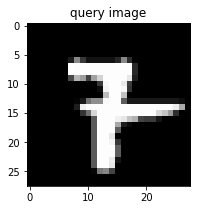

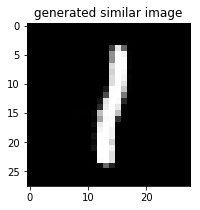

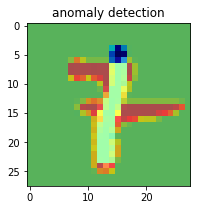

In [ ]:
plt.figure(1, figsize=(3, 3))
plt.title('query image')
plt.imshow(query.reshape(28, 28), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(3, 3))
plt.title('generated similar image')
plt.imshow(pred.reshape(28, 28), cmap=plt.cm.gray)

plt.figure(3, figsize=(3, 3))
plt.title('anomaly detection')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()

Obtain data with label 7 to evaluate anomaly detection performance.







In [ ]:
img_index = 14
label_index = 1
test_image = X_test_original[y_test==label_index][img_index]

Calculate anomaly scores and generate images from the model.








In [ ]:
noise = np.random.normal(0, 1, size=(1, 10))

start = cv2.getTickCount()
score, query, pred, diff = anomaly_detection_encode(test_image, noise, g=g, d=d, e=e, model=model, intermidiate_model=intermidiate_model)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 100
print ('%d label, %d : done'%(label_index, img_index), '%.2f' %score, '%.2fms' %time)

1 label, 14 : done 115.88 6.24ms


Display the input image, generated image, and their difference.








anomaly score :  115.88379135131837


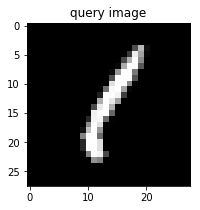

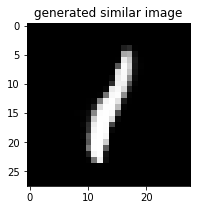

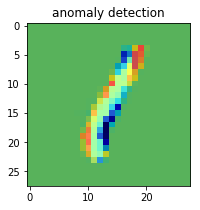

In [ ]:
plt.figure(1, figsize=(3, 3))
plt.title('query image')
plt.imshow(query.reshape(28,28), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(3, 3))
plt.title('generated similar image')
plt.imshow(pred.reshape(28,28), cmap=plt.cm.gray)

plt.figure(3, figsize=(3, 3))
plt.title('anomaly detection')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()


#Let's observe the feature space of noise images, images of digit 1, and images of other digits.

In [ ]:
# Generate 100 random 28x28x1 images
random_images = np.random.uniform(0, 1, (100, 28, 28, 1))
# Generate 100 random noise vectors
random_noise = np.random.uniform(0, 1, (100, 10))

# Obtain the feature extractor model
model = feature_extractor_encode()

# Extract features from the random images
feature_map_of_random = model.predict([random_images, random_noise], verbose=1)


Model: "model_117"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_94 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1776 (Conv2D)            (None, 14, 14, 64)   1088        input_94[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_79 (LeakyReLU)      (None, 14, 14, 64)   0           conv2d_1776[0][0]                
__________________________________________________________________________________________________
dropout_29 (Dropout)            (None, 14, 14, 64)   0           leaky_re_lu_79[0][0]             
__________________________________________________________________________________________

In [ ]:
generate_noise_other = e.predict(X_test_original[y_test != 1][:300])
generate_noise = e.predict(X_test[:100])

100/100 [==============================] - 0s 555us/step
(500, 1024)


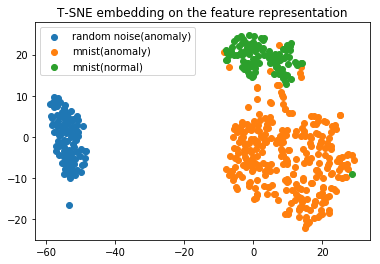

In [ ]:
# Extract features from images with labels other than 1
feature_map_mnist = model.predict([X_test_original[y_test != 1][:300], generate_noise_other], verbose=1)
# Extract features from images with label 1
feature_map_mnist_1 = model.predict([X_test[:100], generate_noise], verbose=1)

# Combine the previously output feature spaces
output = np.concatenate((feature_map_of_random, feature_map_mnist, feature_map_mnist_1))
print(output.shape)
# Keep only the first dimension and flatten the other dimensions
output = output.reshape(output.shape[0], -1)

# Compress the feature space into 2 dimensions for visualization
X_embedded = TSNE(n_components=2).fit_transform(output)
plt.figure(5)
plt.title("T-SNE embedding on the feature representation")
plt.scatter(X_embedded[:100, 0], X_embedded[:100, 1], label='random noise (anomaly)')
plt.scatter(X_embedded[100:400, 0], X_embedded[100:400, 1], label='mnist (anomaly)')
plt.scatter(X_embedded[400:, 0], X_embedded[400:, 1], label='mnist (normal)')
plt.legend()
plt.show()
